In [42]:
import numpy
import urllib
import scipy.optimize
import random
from math import exp
from math import log

random.seed(0)

def parseData(fname):
  for l in urllib.urlopen(fname):
    yield eval(l)

print "Reading data..."
dataFile = open("winequality-white.csv")
header = dataFile.readline()
fields = ["constant"] + header.strip().replace('"','').split(';')
featureNames = fields[:-1]
labelName = fields[-1]
lines = [[1.0] + [float(x) for x in l.split(';')] for l in dataFile]

# Randomly re-shuffle
# numpy.random.shuffle(lines)

X = [l[:-1] for l in lines]
y = [l[-1] > 5 for l in lines]
print "done"

def inner(x,y):
  return sum([x[i]*y[i] for i in range(len(x))])

def sigmoid(x):
  return 1.0 / (1 + exp(-x))

# NEGATIVE Log-likelihood
def f(theta, X, y, lam):
  loglikelihood = 0
  for i in range(len(X)):
    logit = inner(X[i], theta)
    loglikelihood -= log(1 + exp(-logit))
    if not y[i]:
      loglikelihood -= logit
  for k in range(len(theta)):
    loglikelihood -= lam * theta[k]*theta[k]
  # for debugging
  # print "ll =", loglikelihood
  return -loglikelihood

# NEGATIVE Derivative of log-likelihood
def fprime(theta, X, y, lam):
  dl = [0]*len(theta)
  for i in range(len(X)):
    logit = inner(X[i], theta)
    for k in range(len(theta)):
      dl[k] += X[i][k] * (1 - sigmoid(logit))
      if not y[i]:
        dl[k] -= X[i][k]
  for k in range(len(theta)):
    dl[k] -= lam*2*theta[k]
  return numpy.array([-x for x in dl])

X_train = X[:int(len(X)/3)]
y_train = y[:int(len(y)/3)]
X_validate = X[int(len(X)/3):int(2*len(X)/3)]
y_validate = y[int(len(y)/3):int(2*len(y)/3)]
X_test = X[int(2*len(X)/3):]
y_test = y[int(2*len(X)/3):]

# Train                          
def train(lam):
  theta,_,_ = scipy.optimize.fmin_l_bfgs_b(f, [0]*len(X[0]), fprime, pgtol = 10, args = (X_train, y_train, lam))
  return theta

# Predict                                       
def performance(theta):
  scores_train = [inner(theta,x) for x in X_train]
  scores_validate = [inner(theta,x) for x in X_validate]
  scores_test = [inner(theta,x) for x in X_test]

  predictions_train = [s > 0 for s in scores_train]
  predictions_validate = [s > 0 for s in scores_validate]
  predictions_test = [s > 0 for s in scores_test]

  correct_train = [(a==b) for (a,b) in zip(predictions_train,y_train)]
  correct_validate = [(a==b) for (a,b) in zip(predictions_validate,y_validate)]
  correct_test = [(a==b) for (a,b) in zip(predictions_test,y_test)]
  
  acc_train = sum(correct_train) * 1.0 / len(correct_train)
  acc_validate = sum(correct_validate) * 1.0 / len(correct_validate)
  acc_test = sum(correct_test) * 1.0 / len(correct_test)
  return acc_train, acc_validate, acc_test

# Validation pipeline
for lam in [0, 0.01, 1.0, 100.0]:
  theta = train(lam)
  acc_train, acc_validate, acc_test = performance(theta)
  print("lambda = " + str(lam) + ";\ttrain=" + str(acc_train) + "; validate=" + str(acc_validate) + "; test=" + str(acc_test))

Reading data...
done
lambda = 0;	train=0.732843137255; validate=0.720759338641; test=0.778322106552
lambda = 0.01;	train=0.732230392157; validate=0.721984078383; test=0.780159216167
lambda = 1.0;	train=0.726715686275; validate=0.704225352113; test=0.766074709124
lambda = 100.0;	train=0.658700980392; validate=0.630128597673; test=0.696876913656


In [43]:
def performance_accuracy(theta):
    scores_test = [inner(theta,x) for x in X_test]
    predictions_test = [s > 0 for s in scores_test]
    
    # true positives, true negatives, false positives, false negatives 
    TP = sum([(a==b and b==1) for (a,b) in zip(predictions_test,y_test)])
    TN = sum([(a==b and b==0) for (a,b) in zip(predictions_test,y_test)])
    FP = sum([(a!=b and a==1) for (a,b) in zip(predictions_test,y_test)])
    FN = sum([(a!=b and a==0) for (a,b) in zip(predictions_test,y_test)])
    # Balanced Error Rate of the classifier
    # True positive rate (TPR), True negative rate (TNR)
    TPR = TP / (TP+FN+.0)
    TNR = TN / (TN+FP+.0)
    
    print "TP = %d\nTN = %d\nFP = %d\nFN = %d" %(TP, TN, FP, FN)
    print "BER = %f" %(1 - (TPR+TNR)/2)
    
# task 2
theta = train(0.01)
performance_accuracy(theta)

TP = 1129
TN = 145
FP = 321
FN = 38
BER = 0.360702


In [44]:
def rank_prediction(theta):
    scores_test = [inner(theta,x) for x in X_test]
    rank = zip(scores_test, y_test)
    rank.sort(key = lambda x:x[0], reverse = True)
    
    total_relavant = sum(y_test)
      
    for budget in [10, 500, 1000]: 
        relavant = 0
        for i in range(budget):
            relavant += rank[i][1]
            precision = float(relavant)/budget
            recall = float(relavant)/total_relavant 
        print "budget = %f\tprecision = %f\trecall = %f" %(budget, precision, recall)

# task 3
theta = train(0.01)
rank_prediction(theta)

budget = 10.000000	precision = 1.000000	recall = 0.008569
budget = 500.000000	precision = 0.956000	recall = 0.409597
budget = 1000.000000	precision = 0.864000	recall = 0.740360


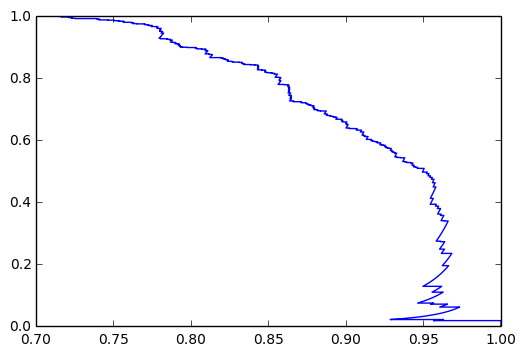

In [45]:
# task 4
import matplotlib.pyplot as plt
theta = train (0.01)
scores_test = [inner(theta,x) for x in X_test]
rank = zip(scores_test, y_test)
rank.sort(key = lambda x:x[0], reverse = True)
precision = []
recall = []

total_relavant = sum(y_test)
for budget in range(1, len(y_test)+1):
    relavant = 0
    for i in range(budget):
        relavant += rank[i][1]
    precision.append(float(relavant)/budget)
    recall.append(float(relavant)/total_relavant)

plt.plot(precision, recall)
plt.show()

In [51]:
# task 5
X_train = numpy.matrix(X_train)
X_mean = numpy.mean(X_train, axis=0)
re = numpy.sum(numpy.square(X_train-X_mean))
print "Reconstruction error = %.3f" %re

Reconstruction error = 3675818.617


In [91]:
# task 6
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(X_train[:, 1:])
print pca.components_

[[ -3.23636346e-04   1.42201752e-04   3.17030713e-04   5.36390435e-02
    9.30284526e-05   2.54030965e-01   9.65655009e-01   3.19990241e-05
   -2.95831396e-04   3.84043646e-04  -1.00526693e-02]
 [ -7.57985623e-03  -1.66366340e-03   1.04742899e-03   5.21677266e-02
    4.49425600e-05   9.65020304e-01  -2.56793964e-01   7.90089050e-06
    5.24900596e-04  -1.09699394e-03  -2.89827657e-03]
 [  1.82124420e-02   2.54680710e-03   3.31838657e-03   9.93221259e-01
   -1.51888372e-04  -6.42297821e-02  -3.91682592e-02   4.30929482e-04
   -6.93199060e-03  -2.85216045e-03  -8.62920933e-02]
 [  1.56811999e-01   3.28220652e-03   1.66866136e-02   8.28549640e-02
   -6.91822288e-03   1.13029682e-03   5.39110108e-03  -9.49080503e-04
    2.68027305e-03   1.30498102e-03   9.83955205e-01]
 [  9.81360642e-01  -1.45890108e-02   5.92643662e-02  -3.17546064e-02
    5.07483182e-04   8.43759364e-03  -1.77578042e-03   6.03725221e-04
   -9.05011239e-02  -9.35630845e-03  -1.54417839e-01]]


In [92]:
# task 7
pca = PCA(n_components=4)
pca.fit(X_train[:, 1:])
print numpy.sum(re) - len(X_train) * numpy.sum(pca.explained_variance_)

1345.47557416


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is depre

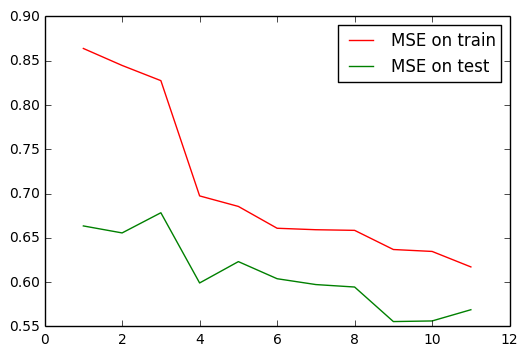

In [100]:
# task 8
pca = PCA(n_components=11)
X_train_pca = pca.fit_transform(X_train[:, 1:])
X_validate_pca = pca.transform(numpy.array(X_validate)[:, 1:])
X_test_pca = pca.transform(numpy.array(X_test)[:, 1:])
y = [l[-1] for l in lines]
y_train = y[:int(len(y)/3)]
y_validate = y[int(len(y)/3):int(2*len(y)/3)]
y_test = y[int(2*len(X)/3):]

from sklearn.linear_model import LinearRegression as LR
lr = LR()
train_mse = []
test_mse = []

for i in range(1, 12):
    lr.fit(X_train_pca[:, :i], y_train)
    train_mse.append(lr.residues_ / len(y_train))
    s = lr.score(X_test_pca[:, :i], y_test)
    v = ((y_test - numpy.mean(y_test))**2).sum()
    test_mse.append((float)((1-s) * v) / len(y_test))
    
plt.plot(range(1, 12), train_mse, 'r', label='MSE on train')
plt.plot(range(1, 12), test_mse, 'g', label='MSE on test')
plt.legend()